## Init

Import basic libraries, agent and tic-tac-toe envorinment classes

In [1]:
import sys
import numpy as np
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from environment import TicTacToeEnv
from agent import *
from utils.utils_ui import obsToBoard, renderQOnBoard

## Training Analysis

Initialize tic-tac-toe envorinment, agent with optimal Q-function and training logs

In [2]:
env = TicTacToeEnv()
agent = Agent()
agent.sym = 'x'
agent.Q = np.load('../static/Q.npy')
logAgent = pd.read_csv('../log/log_agent_training.csv')

Some simple statistics about training process

In [3]:
startTime = min(logAgent.DATETIME)
endTime = max(logAgent.DATETIME)
startTime = datetime.strptime(startTime, '%d/%m/%Y %H:%M:%S')
endTime = datetime.strptime(endTime, '%d/%m/%Y %H:%M:%S')

# eta
totalEtaSeconds = (endTime - startTime).total_seconds()
totalEta = totalEtaSeconds / 60
numEpisodes = len(set(logAgent.EPISODE))
stepsPerEpisode = logAgent.groupby(['EPISODE']).size()

# draw games
draws = logAgent[['EPISODE', 'REWARD']].groupby('EPISODE').agg(['unique'])
draws = draws.reset_index()
draws.columns = ['EPISODE', 'REWARDS']
draws['NUMBER_DISTINCT_REWARDS'] = draws['REWARDS'].apply(lambda x: len(x))
draws['IS_DRAW'] = draws['NUMBER_DISTINCT_REWARDS'].apply(lambda x: 'Y' if x == 2 else 'N')

logAgent = pd.merge(logAgent, 
                    draws[['EPISODE', 'IS_DRAW']], 
                    how = 'left', 
                    on = 'EPISODE')

# agent's wins 
winGames = logAgent[logAgent.IS_DRAW == 'N']
winGames['PREVIOUS_IS_GAME_OVER'] = winGames.groupby(['EPISODE'])['IS_GAME_OVER'].shift(1)
conditionWinnerAgent = (winGames.PLAYER == agent.sym) & (winGames.IS_GAME_OVER) & (~winGames.PREVIOUS_IS_GAME_OVER.astype(bool))

winGames['IS_AGENT_WINNER'] = conditionWinnerAgent.apply(lambda x: 'Y' if x else 'N')

logAgent = pd.merge(logAgent,
                    winGames[conditionWinnerAgent].loc[:,['EPISODE', 'IS_AGENT_WINNER']], 
                    how = 'left', 
                    on = 'EPISODE')

logAgent['IS_AGENT_WINNER'] = logAgent['IS_AGENT_WINNER'].fillna('N')

# number of draws, agent and opponent wins
numDraws = len(set(logAgent[logAgent.IS_DRAW == 'Y'].EPISODE))
numWinsAgent = len(set(logAgent[(logAgent.IS_DRAW == 'N') & (logAgent.IS_AGENT_WINNER == 'Y')].EPISODE))
numWinsAgentOpposite = len(set(logAgent[(logAgent.IS_DRAW == 'N') & (logAgent.IS_AGENT_WINNER == 'N')].EPISODE))

print("Number of episodes:", numEpisodes)
print("Total eta: {0} minutes".format(round(totalEta, 2)))
print("Average eta per episode: {0} seconds".format((round(totalEtaSeconds/numEpisodes, 3))))
print("Average games per second: {0}".format(int(numEpisodes/totalEtaSeconds)))
print("Average number of steps per episode: {0}".format(int(stepsPerEpisode.mean())))
print("Draws: {0} ({1}%)".format(numDraws, round(numDraws*100/numEpisodes, 2)))
print("Agent wins: {0} ({1}%)".format(numWinsAgent, round(numWinsAgent*100/numEpisodes, 2)))
print("Opposite agent wins: {0} ({1}%)".format(numWinsAgentOpposite, round(numWinsAgentOpposite*100/numEpisodes, 2)))

Number of episodes: 100000
Total eta: 4.07 minutes
Average eta per episode: 0.002 seconds
Average games per second: 409
Average number of steps per episode: 7
Draws: 15558 (15.56%)
Agent wins: 76072 (76.07%)
Opposite agent wins: 8370 (8.37%)


Agent's eps and alpha values during the training

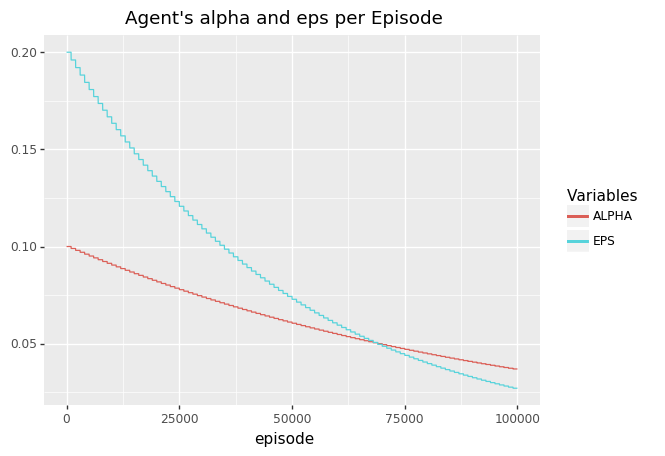

<ggplot: (8768114362873)>

In [4]:
alphaEpsPerEpisode = logAgent[['EPISODE', 'ALPHA', 'EPS']].groupby('EPISODE').agg(['unique'])
alphaEpsPerEpisode = alphaEpsPerEpisode.reset_index()
alphaEpsPerEpisode.columns = ['EPISODE', 'ALPHA', 'EPS']
alphaEpsPerEpisode['ALPHA'] = alphaEpsPerEpisode.apply(lambda row: row['ALPHA'][0], axis = 1)
alphaEpsPerEpisode['EPS'] = alphaEpsPerEpisode.apply(lambda row: row['EPS'][0], axis = 1)
alphaPerEpisode = pd.melt(alphaEpsPerEpisode, id_vars = "EPISODE", var_name = 'VARIABLE', value_name = 'VALUE')

(ggplot(alphaPerEpisode, aes(x = "EPISODE", y = "VALUE")) 
    + geom_line(aes(color = "VARIABLE"))
    + scale_color_discrete(name = "Variables", labels = ("ALPHA", "EPS"))
    + labs(title = "Agent's alpha and eps per Episode", x = 'episode', y = ''))

Agent wins during the training

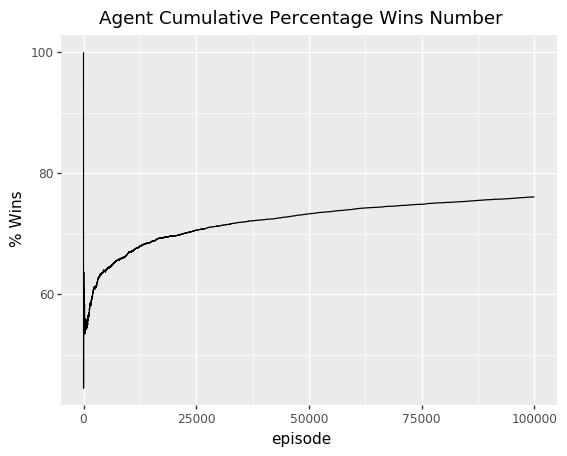

<ggplot: (8768044733753)>

In [5]:
winGames['IS_AGENT_WINNER'] = conditionWinnerAgent.apply(lambda x: 'Y' if x else 'N')
winGamescumulativeCount = winGames.loc[winGames['IS_AGENT_WINNER'] == 'Y', ['EPISODE', 'IS_AGENT_WINNER']]
winGamescumulativeCount['CUM_SUM_NUMBER_AGENT_WINS'] = winGamescumulativeCount.IS_AGENT_WINNER.apply(lambda x: 1).cumsum()
winGamescumulativeCount['PERC_SUM_NUMBER_AGENT_WINS'] = winGamescumulativeCount.apply(lambda row: row['CUM_SUM_NUMBER_AGENT_WINS'] * 100 / row['EPISODE'], axis = 1)

(ggplot(winGamescumulativeCount, aes(x = "EPISODE", y = "PERC_SUM_NUMBER_AGENT_WINS")) 
    + geom_line()
    + labs(title = "Agent Cumulative Percentage Wins Number", x = 'episode', y = '% Wins'))

Agent wins, opponent wins and draws during the training

In [6]:
# custom window over computing number of wins and draws over last N games
widthWindow = 100

winsCumulative = logAgent[['EPISODE', 'IS_DRAW', 'IS_AGENT_WINNER']]
winsCumulative = winsCumulative.drop_duplicates()
winsCumulative['FLAG_AGENT_WIN'] = winsCumulative.apply(lambda row: 1 if row['IS_AGENT_WINNER'] == 'Y' else 0, axis = 1)
winsCumulative['FLAG_DRAW'] = winsCumulative.apply(lambda row: 1 if row['IS_DRAW'] == 'Y' else 0, axis = 1)

agentWinsCountCumSumWindow = np.array(winsCumulative.FLAG_AGENT_WIN).cumsum()
drawsCountCumSumWindow = np.array(winsCumulative.FLAG_DRAW).cumsum()

agentWinsCountCumSumWindow[widthWindow:] = agentWinsCountCumSumWindow[widthWindow:] - agentWinsCountCumSumWindow[:-widthWindow]
drawsCountCumSumWindow[widthWindow:] = drawsCountCumSumWindow[widthWindow:] - drawsCountCumSumWindow[:-widthWindow]

winsCumulative['CUM_NUMBER_AGENT_WINS_LAST_100_GAMES'] = agentWinsCountCumSumWindow
winsCumulative['CUM_NUMBER_DRAWS_LAST_100_GAMES'] = drawsCountCumSumWindow
winsCumulative['WIDTH_WINDOW'] = winsCumulative.apply(lambda row: row['EPISODE'] if row['EPISODE'] < widthWindow else widthWindow, axis = 1) 
winsCumulative['CUM_NUMBER_OPPONENT_WINS_LAST_100_GAMES'] = winsCumulative.apply(lambda row: row['WIDTH_WINDOW'] - (row['CUM_NUMBER_AGENT_WINS_LAST_100_GAMES']+row['CUM_NUMBER_DRAWS_LAST_100_GAMES']), axis = 1)

winsCumulative = winsCumulative[['EPISODE', 'CUM_NUMBER_AGENT_WINS_LAST_100_GAMES', 'CUM_NUMBER_DRAWS_LAST_100_GAMES', 'CUM_NUMBER_OPPONENT_WINS_LAST_100_GAMES']]
winsCumulative = pd.melt(winsCumulative, id_vars = "EPISODE", var_name = 'VARIABLE', value_name = 'VALUE')
winsCumulative = winsCumulative.rename(columns = {"VARIABLE": "WINNER", "VALUE": "COUNT"})

def toWinner(x):
    if x == 'CUM_NUMBER_AGENT_WINS_LAST_100_GAMES':
        return 'Agent'
    elif x == 'CUM_NUMBER_OPPONENT_WINS_LAST_100_GAMES':
        return 'Opponent'
    else:
        return 'Draw'

winsCumulative['WINNER'] = winsCumulative['WINNER'].apply(toWinner)

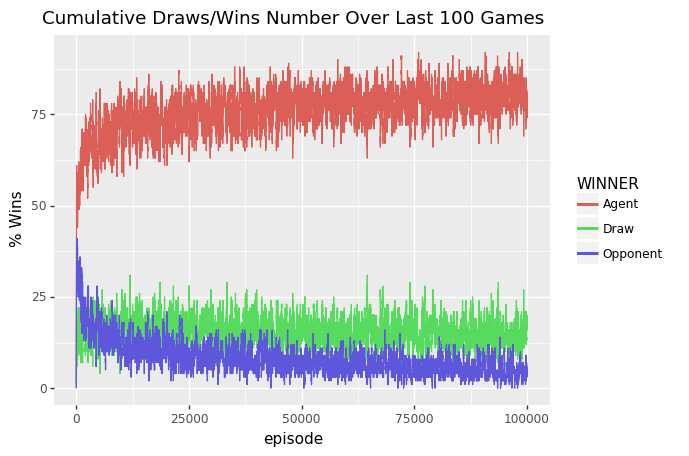

<ggplot: (8768047330757)>

In [7]:
(ggplot(winsCumulative, aes(x = "EPISODE", y = "COUNT", color = "WINNER")) 
    + geom_line()
    + labs(title = "Cumulative Draws/Wins Number Over Last {0} Games".format(widthWindow), x = 'episode', y = '% Wins'))

Time series of steps per episode (*here the last 50 episodes*)

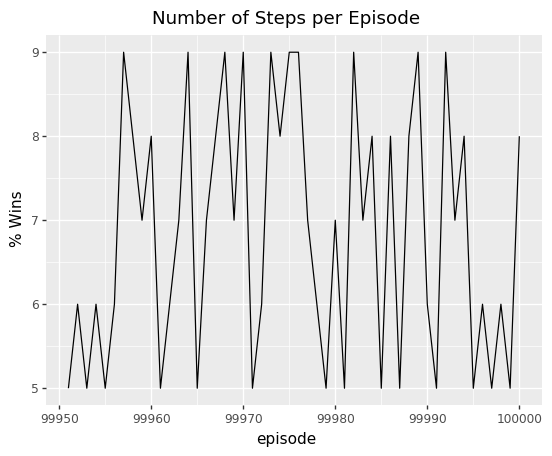

<ggplot: (8767974786041)>

In [9]:
stepsPerEpisode = logAgent.groupby(['EPISODE'])['STEP'].agg(['max']).reset_index()
stepsPerEpisode = stepsPerEpisode.rename(columns = {"max": "NUM_STEPS"})

(ggplot(stepsPerEpisode.loc[99950:,], aes(x = "EPISODE", y = "NUM_STEPS")) 
    + geom_line()
    + labs(title = "Number of Steps per Episode", x = 'episode', y = '% Wins'))

Visualizing $Q(s,a)$

In [10]:
Q_df = pd.DataFrame([(idx, x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]) for idx, x in enumerate(list(agent.Q)) if x.sum() > 0])
newNamesCols = list(Q_df.columns)
newNamesCols = ['obs', 'action_1', 'action_2', 'action_3', 'action_4', 'action_5', 'action_6', 'action_7', 'action_8', 'action_9']
Q_df.columns = newNamesCols

Q_df

,obs,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9
0,51,0.079868,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,52,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.999917,0.0,0.0
2,59,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000754,0.0,0.0
3,65,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.022385,0.0,0.0
4,68,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001328,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2356,18850,0.000000,0.000000,0.961025,0.000000,0.0,0.0,0.000000,0.0,0.0
2357,18877,0.000000,0.000000,0.680998,0.083451,0.0,0.0,0.000000,0.0,0.0
2358,18883,0.000000,0.601363,0.000000,0.040473,0.0,0.0,0.000000,0.0,0.0
2359,18885,0.040473,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


## Analysis of Single Episode

How did the player play during the game?

In [12]:
episode = 99999
logAgent[logAgent.EPISODE == episode]

,DATETIME,EPISODE,STEP,IS_GAME_OVER,PLAYER,ALPHA,EPS,OBS1,OBS2,ACTION,REWARD,Q_VALUE_OBS1,IS_DRAW,IS_AGENT_WINNER
708160,11/01/2021 20:50:50,99999,1,False,x,0.036973,0.027065,0,729,NaN,0.0,NaN,N,Y
708161,11/01/2021 20:50:50,99999,2,False,o,0.036973,0.027065,729,747,"(0, 2)",NaN,NaN,N,Y
708162,11/01/2021 20:50:50,99999,3,False,x,0.036973,0.027065,747,748,"(0, 0)",0.0,[0. 0. 0. 0. 0. 0. 0. 0. 0.],N,Y
708163,11/01/2021 20:50:50,99999,4,False,o,0.036973,0.027065,748,5122,"(2, 1)",NaN,NaN,N,Y
708164,11/01/2021 20:50:50,99999,5,True,x,0.036973,0.027065,5122,5149,"(1, 0)",1.0,[0. 0. 0. 0.99999941 0...,N,Y


In [14]:
game = logAgent[logAgent.EPISODE == episode]
allObsGame = list(zip(game.PLAYER.values, game.OBS2.values))

for step, (player, obs) in enumerate(allObsGame):
    print("\nSTEP:", step+1)
    print('-' * 50)
    print('Player:', player)
    env.board = obsToBoard(obs)
    print("\nObservation: ", env.get_obs())
    print("\n")

    print("\nQ(obs, a):\n")
    renderQOnBoard(env, obs, agent.Q)


STEP: 1
--------------------------------------------------
Player: x

Observation:  [729]



Q(obs, a):

--------------------
  0   0   0 
--------------------
  0   0   0 
--------------------
  x   0   0 
--------------------

STEP: 2
--------------------------------------------------
Player: o

Observation:  [747]



Q(obs, a):

--------------------
  0   0   o 
--------------------
  0   0   0 
--------------------
  x   0   0 
--------------------

STEP: 3
--------------------------------------------------
Player: x

Observation:  [748]



Q(obs, a):

--------------------
  x   0   o 
--------------------
  0   0   0 
--------------------
  x   0   0 
--------------------

STEP: 4
--------------------------------------------------
Player: o

Observation:  [5122]



Q(obs, a):

--------------------
  x   0   o 
--------------------
  1.0   0   0 
--------------------
  x   o   0 
--------------------

STEP: 5
--------------------------------------------------
Player: x

Observatio

Here you can **choose an observation** and see Q values on the board

In [16]:
obs = np.array([59])

env.board = obsToBoard(obs[0])
print("\nObservation: ", env.get_obs())
print('\nBoard:\n', env.board)
print("\n")
env.render()

print("\nQ[obs]: %s" % agent.Q[obs][0].reshape(3,3))

print('\nBoard with Q values:')
renderQOnBoard(env, obs[0], agent.Q)


Observation:  [59]

Board:
 [[ 1 -1  0]
 [ 1  0  0]
 [ 0  0  0]]


-------------
  o   x     
-------------
  o         
-------------
            
-------------

Q[obs]: [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.00075416 0.         0.        ]]

Board with Q values:
--------------------
  o   x   0 
--------------------
  o   0   0 
--------------------
  0.001   0   0 
--------------------


Here you can **choose a situation** during a play and see Q values on the board

In [15]:
env.board = np.array([[1,-1,0],[1,0,0],[0,0,0]])
obs = env._get_obs()

env.board = obsToBoard(obs[0])
print("\nObservation: ", env._get_obs())
print('\nBoard:\n', env.board)
print("\n")
env.render()

print("\nQ(obs, a):\n")
print("Q[obs]: %s" % agent.Q[obs][0].reshape(3,3))
renderQOnBoard(env, obs[0], agent.Q)


Observation:  [59]

Board:
 [[ 1 -1  0]
 [ 1  0  0]
 [ 0  0  0]]


-------------
  o   x     
-------------
  o         
-------------
            
-------------

Q(obs, a):

Q[obs]: [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.00245217 0.         0.        ]]
--------------------
  o   x   0 
--------------------
  o   0   0 
--------------------
  0.002   0   0 
--------------------


Agent takes the greedy action

In [17]:
agent.take_greedy_action(env, [59])

(2, 0)